# Imports

In [113]:
%matplotlib inline

import json
import math
import time
import pytz
import datetime
import cPickle as pickle

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.regularizers import l2
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop
from keras.callbacks import EarlyStopping

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Utilities

In [3]:
def timestamp():
    return int((datetime.datetime.now(tz=pytz.utc) - datetime.datetime(1970, 1, 1, tzinfo=pytz.utc)).total_seconds())

In [93]:
def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around plt.imshow"""
    if cmap is None:
        cmap = 'binary'
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    # plt.colorbar(im, cax=cax)

# Data

In [130]:
f = open('output.pkl', 'rb')
(X_train, Y_train), (X_test, Y_test) = pickle.load(f)
f.close()

In [131]:
X_train = np.array(X_train).astype("float32")
Y_train = np.array(Y_train).astype("float32")
X_test = np.array(X_test).astype("float32")
Y_test = np.array(Y_test).astype("float32")

In [132]:
print(X_train.shape, Y_train.shape, 'train samples')
print(X_test.shape, Y_test.shape, 'test samples')

((124000, 414), (124000, 69), 'train samples')
((3100, 414), (3100, 69), 'test samples')


# Model

In [206]:
model = Sequential()
model.add(Dense(414, 1024, activation='relu', init='normal'))
model.add(Dense(1024, 2048, activation='relu', init='normal'))
model.add(Dense(2048, 69, init='normal'))

In [207]:
# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
model.compile(loss='mse', optimizer='rmsprop')

# Fit

In [190]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
batch_size = 100
nb_epoch = 20
validation_split = 0.1
shuffle = True

history = model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, shuffle=shuffle, validation_split=validation_split, callbacks=[early_stopping])

Train on 111600 samples, validate on 12400 samples
Epoch 0
111600/111600 [==============================] - 123s - loss: 0.0582 - val_loss: 0.0570
Epoch 1
111600/111600 [==============================] - 134s - loss: 0.0569 - val_loss: 0.0569
Epoch 2
111600/111600 [==============================] - 101s - loss: 0.0569 - val_loss: 0.0568
Epoch 3
111600/111600 [==============================] - 98s - loss: 0.0567 - val_loss: 0.0566
Epoch 4
111600/111600 [==============================] - 92s - loss: 0.0565 - val_loss: 0.0562
Epoch 5
111600/111600 [==============================] - 95s - loss: 0.0563 - val_loss: 0.0558
Epoch 6
111600/111600 [==============================] - 100s - loss: 0.0559 - val_loss: 0.0551
Epoch 7
111600/111600 [==============================] - 90s - loss: 0.0556 - val_loss: 0.0549
Epoch 8
111600/111600 [==============================] - 93s - loss: 0.0552 - val_loss: 0.0543
Epoch 9
111600/111600 [==============================] - 90s - loss: 0.0549 - val_loss: 0.

# Evaluate

In [191]:
score = model.evaluate(X_test, Y_test)
score

3100/3100 [==============================] - 0s     


0.04998914349779051

# Save

In [179]:
model_json = json.loads(model.to_json())
model_json["timestamp"] = str(datetime.datetime.now(tz=pytz.utc))
model_json["score"] = score

ts = timestamp()

open('model-%s.json' % ts, 'w').write(json.dumps(model_json))
model.save_weights('weights-%s.hdf5' % ts, overwrite=True)

# Loss

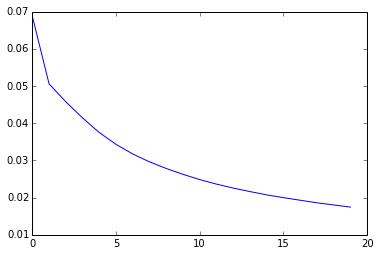

In [180]:
plt.plot(history.history['loss'])

# Weights

In [181]:
W = model.layers[0].W.get_value(borrow=True)
W = np.squeeze(W)
print "W shape:", W.shape

W shape: (414, 1024)


In [182]:
vmin = W.min()
vmax = W.max()

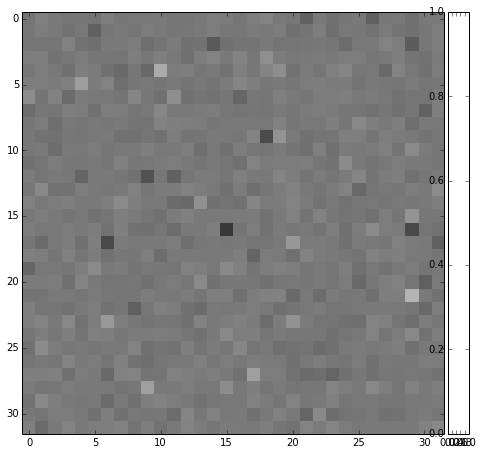

In [203]:
plt.figure(figsize=(8, 8))
nice_imshow(plt.gca(), W[350].reshape(32, 32), vmin=vmin, vmax=vmax)

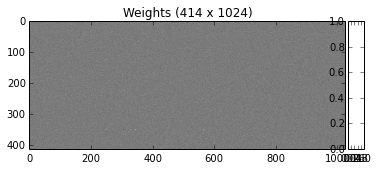

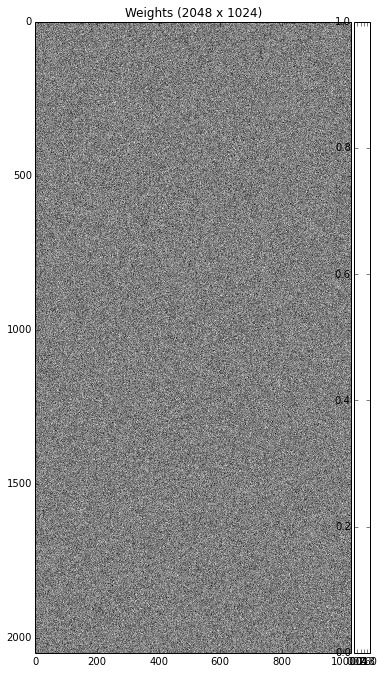

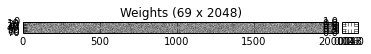

In [205]:
W = np.squeeze(model.layers[0].W.get_value())
plt.figure()
plt.title('Weights (%d x %d)' % W.shape)
nice_imshow(plt.gca(), W)

W = np.squeeze(model.layers[2].W.get_value().T)
plt.figure(figsize=(6, 24))
plt.title('Weights (%d x %d)' % W.shape)
nice_imshow(plt.gca(), W)

W = np.squeeze(model.layers[4].W.get_value().T)
plt.figure()
plt.title('Weights (%d x %d)' % W.shape)
nice_imshow(plt.gca(), W)